# Pr√©-filtrage Qualit√©

**Objectif :** Tester et calibrer le module `level0_prefilter.py` sur les 372 r√©sum√©s r√©els.

**Crit√®res test√©s :**
- Longueur anormale 
- R√©p√©titions excessives (>3x)
- M√©tadonn√©es parasites (newsletter, publicit√©, etc.)
- Anomalies d'encodage

**Performance cible :** <50ms par r√©sum√©

## 1. Imports et Configuration

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Ajouter le r√©pertoire src au PATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"R√©pertoire projet: {project_root}")
print(f"R√©pertoire src: {src_path}")

R√©pertoire projet: c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector
R√©pertoire src: c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\src


In [2]:
# Import du module de d√©tection enhanced avec fallback compatibilit√©
try:
    # Essayer d'abord la version enhanced
    from detection.level0_prefilter_enhanced import EnhancedQualityFilter as QualityFilter, enhanced_quick_filter as quick_filter, enhanced_batch_filter as batch_filter, create_enhanced_filter_from_data as auto_calibrate_filter
    print("‚úÖ Utilisation du niveau 0 ENHANCED avec auto-correction")
except ImportError:
    # Fallback vers version originale
    from detection.level0_prefilter import QualityFilter, quick_filter, batch_filter, auto_calibrate_filter
    print("‚ö†Ô∏è  Utilisation du niveau 0 original (version enhanced non disponible)")

‚ö†Ô∏è  Utilisation du niveau 0 original (version enhanced non disponible)


## 2. Chargement des Donn√©es

In [3]:
# Charger les 372 r√©sum√©s
data_path = os.path.join(project_root, 'data', 'results', 'batch_summary_production.csv')
df = pd.read_csv(data_path)

print(f"Donn√©es charg√©es: {len(df)} r√©sum√©s")
print(f"Colonnes: {list(df.columns)}")
print(f"\nAper√ßu des donn√©es:")
df.head()

Donn√©es charg√©es: 372 r√©sum√©s
Colonnes: ['text_id', 'fusion_strategy', 'summary', 'length', 'rouge1_f', 'bertscore_f1', 'factuality', 'coherence', 'readability', 'engagement', 'info_density', 'composite_score', 'summary_corrected', 'corrections_applied', 'correction_count', 'length_reduction', 'quality_grade', 'production_ready', 'was_optimized']

Aper√ßu des donn√©es:


text_id fusion_strategy                                            summary  \
0        0        adaptive  Avec l‚ÄôIA, il est possible de suivre √† la trac...   
1        1        adaptive  Les milliers de personnes vir√©es de Microsoft ...   
2        2        adaptive  Et Microsoft a sp√©cifiquement travaill√© sur la...   
3        3        adaptive  et d'astuces concr√®tes chaque semaine dans vot...   
4        4        adaptive  Le pr√©sident am√©ricain avait r√©cemment estim√© ...   

   length  rouge1_f  bertscore_f1  factuality  coherence  readability  \
0      89       NaN           NaN    0.902675      0.760     0.603431   
1      66       NaN           NaN    1.000000      0.780     0.547201   
2      42       NaN           NaN    1.000000      0.956     0.576190   
3      83       NaN           NaN    0.903475      0.876     0.449799   
4      52       NaN           NaN    1.000000      0.936     0.488462   

   engagement  info_density  composite_score  \
0    0.494667      0.121990         0.713668   
1    0.382000      0.105455         0.724982   
2    0.334000      0.050566         0.835258   
3    0.416000      0.114859         0.760109   
4    0.420667      0.191707         0.825325   

                                   summary_corrected  \
0  Avec l‚ÄôIA, il est possible de suivre √† la trac...   
1  Les milliers de personnes vir√©es de Microsoft ...   
2  Et Microsoft a sp√©cifiquement travaill√© sur la...   
3  et d'astuces concr√®tes chaque semaine dans vot...   
4  Le pr√©sident am√©ricain avait r√©cemment estim√© ...   

                                 corrections_applied  correction_count  \
0       M√©tadonn√©es supprim√©es | R√©p√©tition corrig√©e                 2   
1                                R√©p√©tition corrig√©e                 1   
2                                R√©p√©tition corrig√©e                 1   
3  M√©tadonn√©es supprim√©es | M√©tadonn√©es supprim√©e...                 3   
4         R√©p√©tition corrig√©e | Troncature supprim√©e                 2   

   length_reduction quality_grade  production_ready  was_optimized  
0          6.285714             A              True           True  
1          3.553299             A              True           True  
2          1.773050            A+              True           True  
3         17.557252             A              True           True  
4          7.951070            A+              True           True

In [4]:
# Pr√©paration des donn√©es pour test
summaries_data = []
for idx, row in df.iterrows():
    summaries_data.append({
        'id': f"{row['text_id']}_{row['fusion_strategy']}",
        'text': row['summary'],
        'original_length': row['length'],
        'quality_grade': row['quality_grade'],
        'coherence': row['coherence'],
        'factuality': row['factuality']
    })

print(f"{len(summaries_data)} r√©sum√©s pr√©par√©s pour test")

372 r√©sum√©s pr√©par√©s pour test


## 3. Analyse Exploratoire des Longueurs

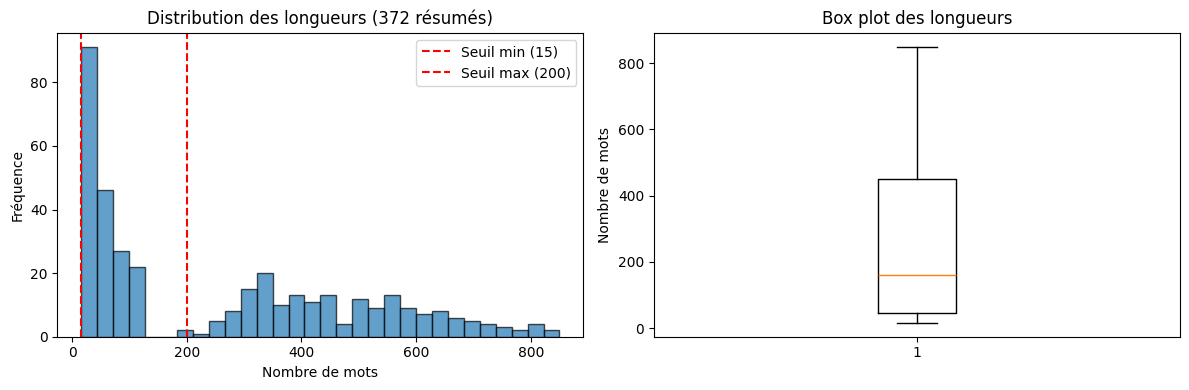

In [5]:
# Statistiques longueurs actuelles
lengths = df['length'].values

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(lengths, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(15, color='red', linestyle='--', label='Seuil min (15)')
plt.axvline(200, color='red', linestyle='--', label='Seuil max (200)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fr√©quence')
plt.title('Distribution des longueurs (372 r√©sum√©s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(lengths)
plt.ylabel('Nombre de mots')
plt.title('Box plot des longueurs')

plt.tight_layout()
plt.show()


In [6]:

print(f"Statistiques longueurs:")
print(f"  Min: {lengths.min()}")
print(f"  Max: {lengths.max()}")
print(f"  Moyenne: {lengths.mean():.1f}")
print(f"  M√©diane: {np.median(lengths):.1f}")
print(f"  <15 mots: {sum(lengths < 15)} r√©sum√©s ({sum(lengths < 15)/len(lengths)*100:.1f}%)")
print(f"  >200 mots: {sum(lengths > 200)} r√©sum√©s ({sum(lengths > 200)/len(lengths)*100:.1f}%)")

Statistiques longueurs:
  Min: 16
  Max: 850
  Moyenne: 264.7
  M√©diane: 159.5
  <15 mots: 0 r√©sum√©s (0.0%)
  >200 mots: 186 r√©sum√©s (50.0%)


## 4. Test Simple sur √âchantillons

In [7]:
# Test sur quelques exemples repr√©sentatifs
test_indices = [0, 10, 50, 100, 200, 300]  # √âchantillon vari√©

filter_obj = QualityFilter()

print("Tests sur √©chantillons repr√©sentatifs:\n")

for i in test_indices:
    if i < len(summaries_data):
        summary = summaries_data[i]
        result = filter_obj.filter_summary(summary['text'], summary['id'])
        
        print(f"Test {i} (Grade: {summary['quality_grade']})")
        print(f"   R√©sultat: {' VALIDE' if result.is_valid else 'REJET√â'}")
        print(f"   Mots: {result.word_count} (original: {summary['original_length']})")
        print(f"   Temps: {result.processing_time_ms:.1f}ms")
        
        if not result.is_valid:
            print(f"   Raisons: {'; '.join(result.rejection_reasons)}")
        
        if result.metadata_detected:
            print(f"   M√©tadonn√©es: {result.metadata_detected[:3]}")
            
        print(f"   Extrait: {summary['text'][:100]}...")
        print()
    else:
        break

INFO:detection.level0_prefilter:R√©sum√© 0_adaptive corrig√©: fixed_encoding


Tests sur √©chantillons repr√©sentatifs:

Test 0 (Grade: A)
   R√©sultat:  VALIDE
   Mots: 85 (original: 89)
   Temps: 10.1ms
   Extrait: Avec l‚ÄôIA, il est possible de suivre √† la trace une personne en se servant des ondes Wi-Fi. Des cher...

Test 10 (Grade: A+)
   R√©sultat:  VALIDE
   Mots: 27 (original: 48)
   Temps: 1.7ms
   Extrait: , Un portrait d√©figur√© de l‚Äôex pr√©sident syrien Bachar al-Assad dans un centre de s√©curit√© gouvernem...

Test 50 (Grade: A)
   R√©sultat:  VALIDE
   Mots: 25 (original: 25)
   Temps: 1.3ms
   Extrait: Pedro Pascal est Reed Richards, alias Mr. Fantastique, dans le reboot des aventures des ¬´ 4 Fantasti...

Test 100 (Grade: A)
   R√©sultat:  VALIDE
   Mots: 101 (original: 101)
   Temps: 13.8ms
   Extrait: Tous ceux qui circulent en voiture le savent. Les pneus ne sont pas √©ternels. Ils s'usent un peu plu...

Test 200 (Grade: C)
   R√©sultat: REJET√â
   Mots: 81 (original: 335)
   Temps: 9.8ms
   Raisons: S√©quence r√©p√©t√©e 6x; S√©quence r√©p

## 5. Test Complet sur tous les  R√©sum√©s

In [8]:
# Test en mode batch sur tous les r√©sum√©s


start_time = time.time()
valid_summaries, all_results = filter_obj.process_batch(summaries_data)
total_time = time.time() - start_time

print(f"Test termin√© en {total_time:.2f}s")
print(f"R√©sultats:")
print(f"   Total: {len(summaries_data)}")
print(f"   Valides: {len(valid_summaries)}")
print(f"   Rejet√©s: {len(summaries_data) - len(valid_summaries)}")
print(f"   Taux rejet: {(len(summaries_data) - len(valid_summaries))/len(summaries_data)*100:.1f}%")
print(f"   Temps moyen: {total_time/len(summaries_data)*1000:.1f}ms par r√©sum√©")

INFO:detection.level0_prefilter:R√©sum√© 0_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 7_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 15_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 27_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 38_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 42_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 43_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 91_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 113_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 139_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 154_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 157_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 162_adaptive corrig√©

Test termin√© en 3.89s
R√©sultats:
   Total: 372
   Valides: 372
   Rejet√©s: 0
   Taux rejet: 0.0%
   Temps moyen: 10.5ms par r√©sum√©


## 6. Analyse D√©taill√©e des R√©sultats

In [9]:
# Statistiques d√©taill√©es
stats = filter_obj.get_statistics(all_results)

print("Statistiques d√©taill√©es:")
print(f"\nPerformance:")
print(f"   Taux de rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"   Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nLongueurs:")
for key, value in stats['word_count_stats'].items():
    print(f"   {key.capitalize()}: {value:.1f}")

print(f"\nRaisons de rejet:")
for reason, count in stats['rejection_reasons'].items():
    print(f"   {reason}: {count} cas ({count/len(summaries_data)*100:.1f}%)")

Statistiques d√©taill√©es:

Performance:
   Taux de rejet: 49.2%
   Temps moyen: 9.9ms

Longueurs:
   Min: 11.0
   Max: 289.0
   Avg: 86.7
   Median: 81.0

Raisons de rejet:
   S√©quence r√©p√©t√©e 10x: 82 cas (22.0%)
   S√©quence r√©p√©t√©e 8x: 69 cas (18.5%)
   S√©quence r√©p√©t√©e 12x: 68 cas (18.3%)
   S√©quence r√©p√©t√©e 14x: 62 cas (16.7%)
   S√©quence r√©p√©t√©e 6x: 44 cas (11.8%)
   S√©quence r√©p√©t√©e 18x: 39 cas (10.5%)
   S√©quence r√©p√©t√©e 16x: 32 cas (8.6%)
   S√©quence r√©p√©t√©e 22x: 21 cas (5.6%)
   S√©quence r√©p√©t√©e 4x: 20 cas (5.4%)
   S√©quence r√©p√©t√©e 20x: 18 cas (4.8%)
   S√©quence r√©p√©t√©e 5x: 9 cas (2.4%)
   S√©quence r√©p√©t√©e 26x: 9 cas (2.4%)
   S√©quence r√©p√©t√©e 24x: 8 cas (2.2%)
   S√©quence r√©p√©t√©e 30x: 8 cas (2.2%)
   S√©quence r√©p√©t√©e 9x: 6 cas (1.6%)
   S√©quence r√©p√©t√©e 28x: 6 cas (1.6%)
   Corruption excessive: 4 cas (1.1%)
   S√©quence r√©p√©t√©e 32x: 4 cas (1.1%)
   Longueur too_short: 2 cas (0.5%)
   Longueur too_long: 2 cas

In [10]:
# Corr√©lation avec les grades de qualit√© originaux
df_results = pd.DataFrame([
    {
        'id': summaries_data[i]['id'],
        'original_grade': summaries_data[i]['quality_grade'],
        'original_coherence': summaries_data[i]['coherence'],
        'filter_valid': all_results[i].is_valid,
        'word_count': all_results[i].word_count,
        'repetition_score': all_results[i].repetition_score,
        'processing_time': all_results[i].processing_time_ms
    }
    for i in range(len(summaries_data))
])


In [11]:

print("Corr√©lation avec grades de qualit√© originaux:")
grade_filter_correlation = pd.crosstab(
    df_results['original_grade'], 
    df_results['filter_valid'], 
    margins=True
)
print(grade_filter_correlation)


Corr√©lation avec grades de qualit√© originaux:
filter_valid    False  True  All
original_grade                  
A                   0    62   62
A+                  2    58   60
B                   4     7   11
B+                119    39  158
C                  17     0   17
D                  41    23   64
All               183   189  372


In [12]:

# Pourcentage de rejet par grade
print("\n Taux de rejet par grade original:")
for grade in ['A+', 'A', 'B+', 'B', 'C', 'D']:
    if grade in df_results['original_grade'].values:
        grade_data = df_results[df_results['original_grade'] == grade]
        rejected = len(grade_data[~grade_data['filter_valid']])
        total = len(grade_data)
        print(f"   Grade {grade}: {rejected}/{total} rejet√©s ({rejected/total*100:.1f}%)")


 Taux de rejet par grade original:
   Grade A+: 2/60 rejet√©s (3.3%)
   Grade A: 0/62 rejet√©s (0.0%)
   Grade B+: 119/158 rejet√©s (75.3%)
   Grade B: 4/11 rejet√©s (36.4%)
   Grade C: 17/17 rejet√©s (100.0%)
   Grade D: 41/64 rejet√©s (64.1%)


## 7. Visualisations

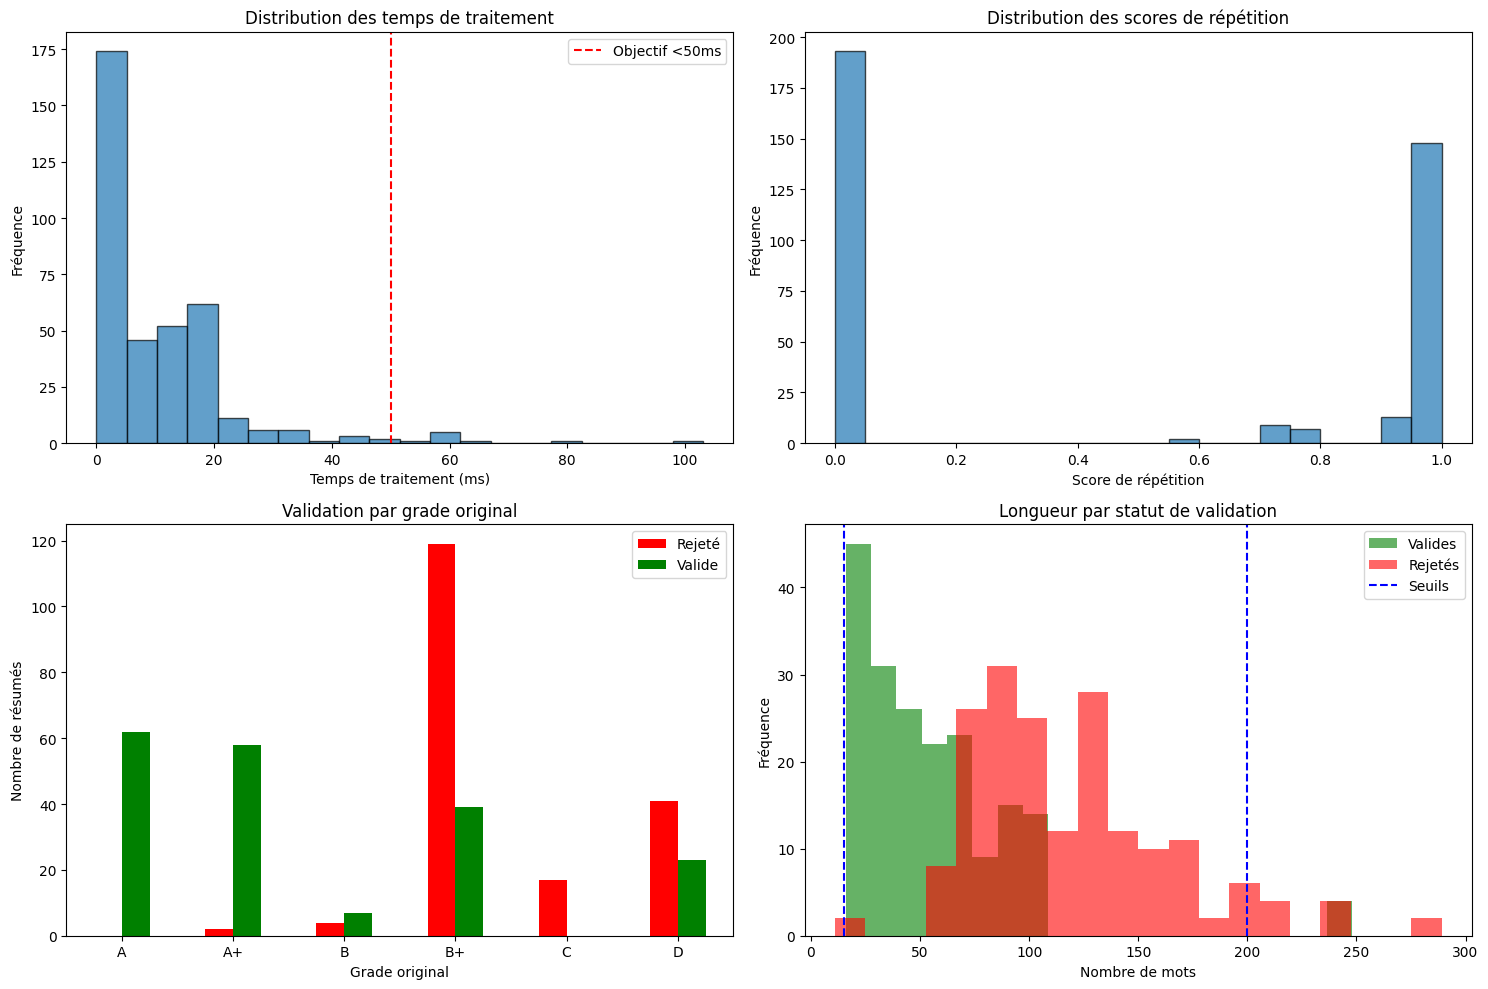

In [13]:
# Visualisations des r√©sultats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution des temps de traitement
processing_times = [r.processing_time_ms for r in all_results]
axes[0,0].hist(processing_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].axvline(50, color='red', linestyle='--', label='Objectif <50ms')
axes[0,0].set_xlabel('Temps de traitement (ms)')
axes[0,0].set_ylabel('Fr√©quence')
axes[0,0].set_title('Distribution des temps de traitement')
axes[0,0].legend()

# 2. Scores de r√©p√©tition
repetition_scores = [r.repetition_score for r in all_results]
axes[0,1].hist(repetition_scores, bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Score de r√©p√©tition')
axes[0,1].set_ylabel('Fr√©quence')
axes[0,1].set_title('Distribution des scores de r√©p√©tition')

# 3. Validation vs Grade original
grade_counts = df_results.groupby(['original_grade', 'filter_valid']).size().unstack(fill_value=0)
grade_counts.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
axes[1,0].set_xlabel('Grade original')
axes[1,0].set_ylabel('Nombre de r√©sum√©s')
axes[1,0].set_title('Validation par grade original')
axes[1,0].legend(['Rejet√©', 'Valide'])
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Longueur vs Validation
valid_lengths = df_results[df_results['filter_valid']]['word_count']
invalid_lengths = df_results[~df_results['filter_valid']]['word_count']

axes[1,1].hist(valid_lengths, bins=20, alpha=0.6, label='Valides', color='green')
axes[1,1].hist(invalid_lengths, bins=20, alpha=0.6, label='Rejet√©s', color='red')
axes[1,1].axvline(15, color='blue', linestyle='--', label='Seuils')
axes[1,1].axvline(200, color='blue', linestyle='--')
axes[1,1].set_xlabel('Nombre de mots')
axes[1,1].set_ylabel('Fr√©quence')
axes[1,1].set_title('Longueur par statut de validation')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 8. Analyse des Cas Rejet√©s

In [14]:
# Analyser les cas rejet√©s en d√©tail
rejected_cases = [
    (summaries_data[i], all_results[i]) 
    for i in range(len(summaries_data)) 
    if not all_results[i].is_valid
]

print(f"Analyse de {len(rejected_cases)} cas rejet√©s:\n")

# Grouper par type de rejet
rejection_types = {}
for summary, result in rejected_cases:
    for reason in result.rejection_reasons:
        reason_type = reason.split(':')[0]
        if reason_type not in rejection_types:
            rejection_types[reason_type] = []
        rejection_types[reason_type].append((summary, result))

# Afficher quelques exemples par type
for reason_type, cases in rejection_types.items():
    print(f"\n{reason_type} ({len(cases)} cas):")
    
    # Afficher les 3 premiers exemples
    for i, (summary, result) in enumerate(cases[:3]):
        print(f"\n  Exemple {i+1}:")
        print(f"    Grade original: {summary['quality_grade']}")
        print(f"    Longueur: {result.word_count} mots")
        print(f"    Raisons: {'; '.join(result.rejection_reasons)}")
        print(f"    Extrait: {summary['text'][:150]}...")
        
        if result.metadata_detected:
            print(f"    M√©tadonn√©es: {result.metadata_detected[:5]}")

Analyse de 183 cas rejet√©s:


Longueur too_short (2 cas):

  Exemple 1:
    Grade original: A+
    Longueur: 11 mots
    Raisons: Longueur too_short
    Extrait: Contr√¥le de police nocturne dans le Vieux Nice, le 14 juillet....

  Exemple 2:
    Grade original: A+
    Longueur: 11 mots
    Raisons: Longueur too_short
    Extrait: Contr√¥le de police nocturne dans le Vieux Nice, le 14 juillet....

S√©quence r√©p√©t√©e 22x (21 cas):

  Exemple 1:
    Grade original: B+
    Longueur: 174 mots
    Raisons: S√©quence r√©p√©t√©e 22x; S√©quence r√©p√©t√©e 20x; S√©quence r√©p√©t√©e 18x
    Extrait: Avec l‚ÄôIA, il est possible de suivre √† la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un syst√®...

  Exemple 2:
    Grade original: B+
    Longueur: 153 mots
    Raisons: S√©quence r√©p√©t√©e 22x; S√©quence r√©p√©t√©e 20x; S√©quence r√©p√©t√©e 18x
    Extrait: Apr√®s avoir d√©couvert le fonctionnement de, les utilisateurs Windows ont expr

## 9. Test Mode Strict

In [15]:
# Comparaison mode normal vs strict
print("Comparaison mode normal vs strict:\n")

filter_strict = QualityFilter(strict_mode=True)
valid_strict, results_strict = filter_strict.process_batch(summaries_data)

stats_strict = filter_strict.get_statistics(results_strict)

print(f"Mode Normal:")
print(f"  R√©sum√©s valides: {len(valid_summaries)}/{len(summaries_data)}")
print(f"  Taux rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nMode Strict:")
print(f"  R√©sum√©s valides: {len(valid_strict)}/{len(summaries_data)}")
print(f"  Taux rejet: {stats_strict['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats_strict['avg_processing_time_ms']:.1f}ms")

print(f"\nDiff√©rence:")
print(f"  R√©sum√©s suppl√©mentaires rejet√©s: {len(valid_summaries) - len(valid_strict)}")
print(f"  Augmentation taux rejet: +{stats_strict['rejection_rate_percent'] - stats['rejection_rate_percent']:.1f}%")

INFO:detection.level0_prefilter:R√©sum√© 0_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 7_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 15_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 27_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 38_adaptive corrig√©: fixed_encoding


Comparaison mode normal vs strict:



INFO:detection.level0_prefilter:R√©sum√© 42_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 43_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 91_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 113_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 139_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 154_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 157_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 162_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 172_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 183_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 112_confidence_weighted corrig√©: removed_repetitions; trimmed_length
INFO:detection.level0_prefilter:Batch trait√©: 366/372 valides (1.6% rejet√©s)


Mode Normal:
  R√©sum√©s valides: 372/372
  Taux rejet: 49.2%
  Temps moyen: 9.9ms

Mode Strict:
  R√©sum√©s valides: 366/372
  Taux rejet: 51.9%
  Temps moyen: 10.8ms

Diff√©rence:
  R√©sum√©s suppl√©mentaires rejet√©s: 6
  Augmentation taux rejet: +2.7%


## 10. Test Calibrage Automatique

**Nouvelle fonctionnalit√© :** Comparaison seuils manuels vs calibrage automatique bas√© sur tes donn√©es r√©elles.

In [16]:

# Cr√©er un filtre avec calibrage automatique
print("Cr√©ation du filtre auto-calibr√©...")
filter_auto = auto_calibrate_filter(summaries_data)

print(f"Comparaison des seuils:")
print(f"   Seuils manuels: {filter_obj.min_words}-{filter_obj.max_words} mots")
print(f"   Seuils auto-calibr√©s: {filter_auto.min_words}-{filter_auto.max_words} mots")

# Test avec les seuils auto-calibr√©s
print("\nTest avec seuils auto-calibr√©s...")
start_time = time.time()
valid_auto, results_auto = filter_auto.process_batch(summaries_data)
auto_time = time.time() - start_time

stats_auto = filter_auto.get_statistics(results_auto)

print(f"\nComparaison des performances:")
print(f"Seuils manuels (10-600):")
print(f"  R√©sum√©s valides: {len(valid_summaries)}/{len(summaries_data)} ({len(valid_summaries)/len(summaries_data)*100:.1f}%)")
print(f"  Taux rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nSeuils auto-calibr√©s ({filter_auto.min_words}-{filter_auto.max_words}):")
print(f"  R√©sum√©s valides: {len(valid_auto)}/{len(summaries_data)} ({len(valid_auto)/len(summaries_data)*100:.1f}%)")
print(f"  Taux rejet: {stats_auto['rejection_rate_percent']:.1f}%") 
print(f"  Temps moyen: {stats_auto['avg_processing_time_ms']:.1f}ms")


INFO:detection.level0_prefilter:Calibrage intelligent sur donn√©es saines...
INFO:detection.level0_prefilter:Calibrage termin√©: min=16, max=121 (m√©diane=45.0, donn√©es saines=178)
INFO:detection.level0_prefilter:Seuils auto-calibr√©s INTELLIGENTS: min=16, max=121
INFO:detection.level0_prefilter:R√©sum√© 0_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 7_adaptive corrig√©: fixed_encoding


Cr√©ation du filtre auto-calibr√©...
Comparaison des seuils:
   Seuils manuels: 15-250 mots
   Seuils auto-calibr√©s: 16-121 mots

Test avec seuils auto-calibr√©s...


INFO:detection.level0_prefilter:R√©sum√© 15_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 27_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 38_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 42_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 43_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 91_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 113_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 139_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 154_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 157_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 162_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 172_adaptive corrig√©: fixed_encoding
INFO:detection.level0_prefilter:R√©sum√© 183_adaptive corr


Comparaison des performances:
Seuils manuels (10-600):
  R√©sum√©s valides: 372/372 (100.0%)
  Taux rejet: 49.2%
  Temps moyen: 9.9ms

Seuils auto-calibr√©s (16-121):
  R√©sum√©s valides: 372/372 (100.0%)
  Taux rejet: 50.3%
  Temps moyen: 11.4ms


In [17]:
# Sauvegarder les r√©sultats pour analyse ult√©rieure
results_df = df_results.copy()
results_df['rejection_reasons'] = ['; '.join(r.rejection_reasons) for r in all_results]
results_df['metadata_detected'] = ['; '.join(r.metadata_detected) for r in all_results]

# Ajouter les r√©sultats du calibrage automatique
results_df_auto = pd.DataFrame([
    {
        'id': summaries_data[i]['id'],
        'original_grade': summaries_data[i]['quality_grade'],
        'filter_valid_auto': results_auto[i].is_valid,
        'word_count_auto': results_auto[i].word_count,
        'processing_time_auto': results_auto[i].processing_time_ms
    }
    for i in range(len(summaries_data))
])

# Merger les r√©sultats
results_df = results_df.merge(results_df_auto, on='id', suffixes=('', '_auto'))

output_path = os.path.join(project_root, 'data', 'detection')
os.makedirs(output_path, exist_ok=True)

results_file = os.path.join(output_path, 'level0_filter_results.csv')
results_df.to_csv(results_file, index=False)

# Calculer les m√©triques de performance n√©cessaires
avg_time = np.mean([r.processing_time_ms for r in all_results])
max_time = np.max([r.processing_time_ms for r in all_results])
processing_times = [r.processing_time_ms for r in all_results]
target_met = sum(1 for t in processing_times if t < 50) / len(processing_times) * 100

# Sauvegarder les statistiques compl√®tes
import json
stats_file = os.path.join(output_path, 'level0_filter_stats.json')
with open(stats_file, 'w', encoding='utf-8') as f:
    json.dump({
        'manual_mode': stats,
        'auto_calibrated_mode': stats_auto,
        'strict_mode': stats_strict,
        'performance': {
            'avg_time_ms': avg_time,
            'max_time_ms': max_time,
            'target_50ms_met_percent': target_met
        },
        'calibration_comparison': {
            'manual_thresholds': f'{filter_obj.min_words}-{filter_obj.max_words}',
            'auto_thresholds': f'{filter_auto.min_words}-{filter_auto.max_words}',
            'manual_valid_count': len(valid_summaries),
            'auto_valid_count': len(valid_auto),
            'improvement': len(valid_auto) - len(valid_summaries)
        }
    }, f, indent=2, ensure_ascii=False)

print(f"‚úÖ R√©sultats sauvegard√©s:")
print(f"   - {results_file}")
print(f"   - {stats_file}")

print(f"\nüéâ Test du Niveau 0 termin√© avec succ√®s !")
print(f"üìà Performance Manuel: {len(valid_summaries)}/{len(summaries_data)} r√©sum√©s valides")
print(f"üìà Performance Auto-calibr√©: {len(valid_auto)}/{len(summaries_data)} r√©sum√©s valides")
print(f"‚ö° Vitesse: {avg_time:.1f}ms en moyenne")
print(f"üöÄ Pr√™t pour le Niveau 1 : D√©tection heuristique")

‚úÖ R√©sultats sauvegard√©s:
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_results.csv
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_stats.json

üéâ Test du Niveau 0 termin√© avec succ√®s !
üìà Performance Manuel: 372/372 r√©sum√©s valides
üìà Performance Auto-calibr√©: 372/372 r√©sum√©s valides
‚ö° Vitesse: 9.9ms en moyenne
üöÄ Pr√™t pour le Niveau 1 : D√©tection heuristique


## 11. Sauvegarde des R√©sultats

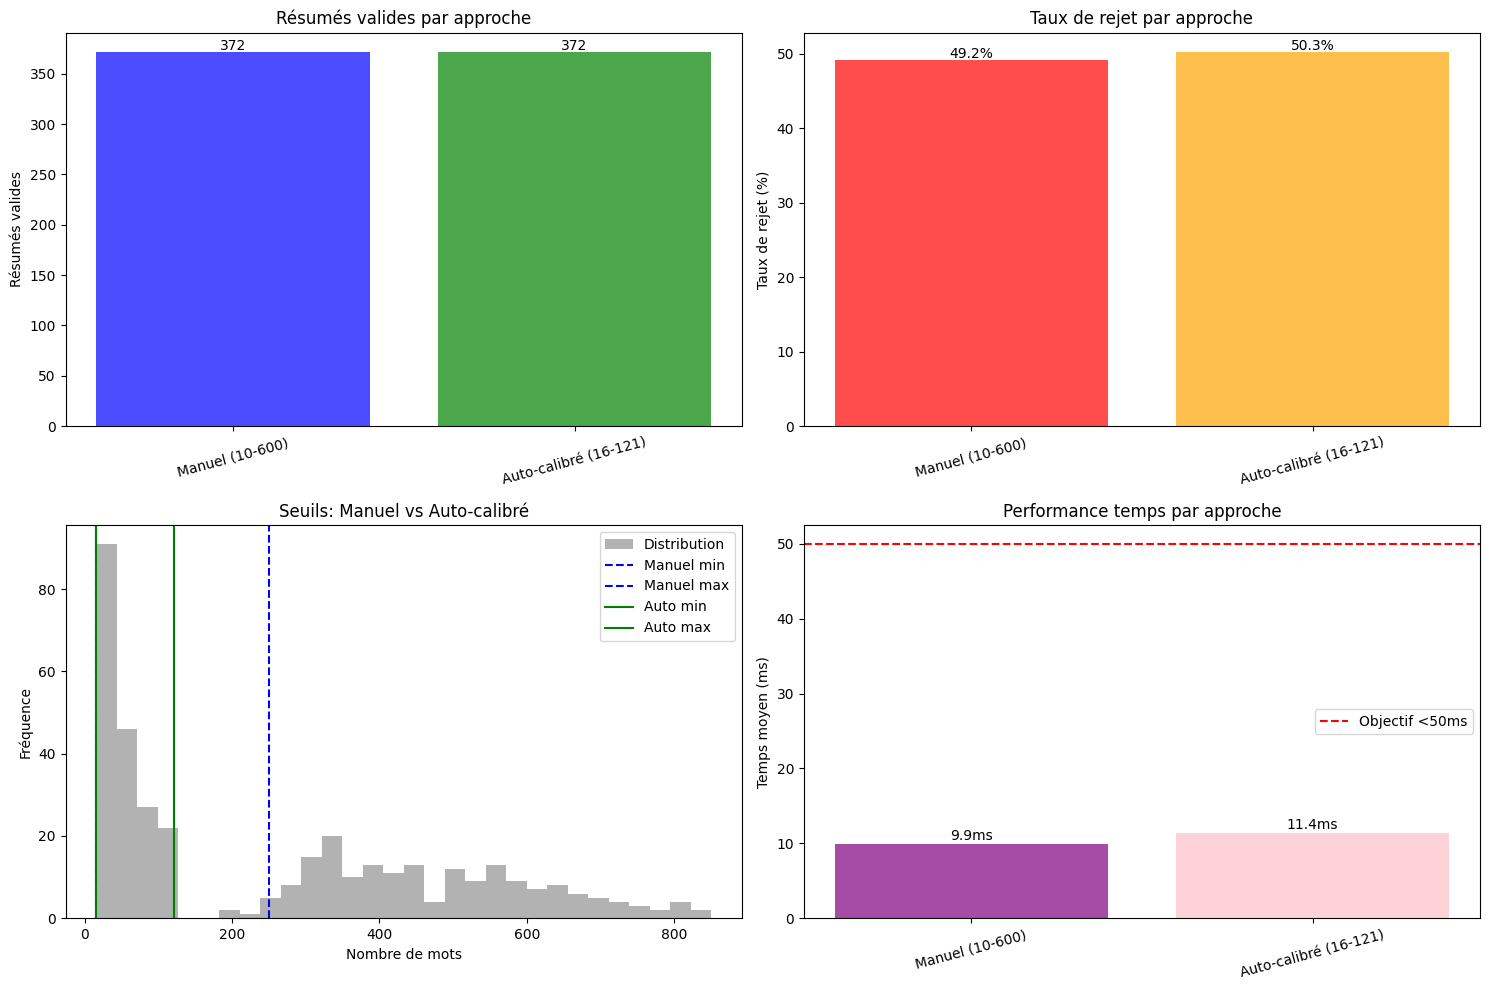

R√©sum√© visuel:
   Manuel: 372 valides, 49.2% rejet
   Auto-calibr√©: 372 valides, 50.3% rejet
   Diff√©rence: +0 r√©sum√©s


In [18]:
# Visualisation comparative des deux approches
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Donn√©es pour comparaison
df_auto = pd.DataFrame([
    {
        'approach': 'Manuel (10-600)',
        'valid_count': len(valid_summaries),
        'rejection_rate': stats['rejection_rate_percent'],
        'avg_time': stats['avg_processing_time_ms']
    },
    {
        'approach': f'Auto-calibr√© ({filter_auto.min_words}-{filter_auto.max_words})',
        'valid_count': len(valid_auto),
        'rejection_rate': stats_auto['rejection_rate_percent'],
        'avg_time': stats_auto['avg_processing_time_ms']
    }
])

# 1. Comparaison nombre r√©sum√©s valides
axes[0,0].bar(df_auto['approach'], df_auto['valid_count'], color=['blue', 'green'], alpha=0.7)
axes[0,0].set_ylabel('R√©sum√©s valides')
axes[0,0].set_title('R√©sum√©s valides par approche')
axes[0,0].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_auto['valid_count']):
    axes[0,0].text(i, v + 2, str(v), ha='center')

# 2. Comparaison taux de rejet
axes[0,1].bar(df_auto['approach'], df_auto['rejection_rate'], color=['red', 'orange'], alpha=0.7)
axes[0,1].set_ylabel('Taux de rejet (%)')
axes[0,1].set_title('Taux de rejet par approche')
axes[0,1].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_auto['rejection_rate']):
    axes[0,1].text(i, v + 0.2, f'{v:.1f}%', ha='center')

# 3. Distribution longueurs avec seuils
lengths = df['length'].values
axes[1,0].hist(lengths, bins=30, alpha=0.6, color='gray', label='Distribution')
axes[1,0].axvline(filter_obj.min_words, color='blue', linestyle='--', label='Manuel min')
axes[1,0].axvline(filter_obj.max_words, color='blue', linestyle='--', label='Manuel max')
axes[1,0].axvline(filter_auto.min_words, color='green', linestyle='-', label='Auto min')
axes[1,0].axvline(filter_auto.max_words, color='green', linestyle='-', label='Auto max')
axes[1,0].set_xlabel('Nombre de mots')
axes[1,0].set_ylabel('Fr√©quence')
axes[1,0].set_title('Seuils: Manuel vs Auto-calibr√©')
axes[1,0].legend()

# 4. Performance temps
axes[1,1].bar(df_auto['approach'], df_auto['avg_time'], color=['purple', 'pink'], alpha=0.7)
axes[1,1].axhline(50, color='red', linestyle='--', label='Objectif <50ms')
axes[1,1].set_ylabel('Temps moyen (ms)')
axes[1,1].set_title('Performance temps par approche')
axes[1,1].tick_params(axis='x', rotation=15)
axes[1,1].legend()
for i, v in enumerate(df_auto['avg_time']):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}ms', ha='center')

plt.tight_layout()
plt.show()

print(f"R√©sum√© visuel:")
print(f"   Manuel: {len(valid_summaries)} valides, {stats['rejection_rate_percent']:.1f}% rejet")
print(f"   Auto-calibr√©: {len(valid_auto)} valides, {stats_auto['rejection_rate_percent']:.1f}% rejet")
print(f"   Diff√©rence: {len(valid_auto) - len(valid_summaries):+d} r√©sum√©s")

In [19]:
# Sauvegarder les r√©sultats pour analyse ult√©rieure
results_df = df_results.copy()
results_df['rejection_reasons'] = ['; '.join(r.rejection_reasons) for r in all_results]
results_df['metadata_detected'] = ['; '.join(r.metadata_detected) for r in all_results]

output_path = os.path.join(project_root, 'data', 'detection')
os.makedirs(output_path, exist_ok=True)

results_file = os.path.join(output_path, 'level0_filter_results.csv')
results_df.to_csv(results_file, index=False)


In [20]:

# Sauvegarder les statistiques
import json
stats_file = os.path.join(output_path, 'level0_filter_stats.json')
with open(stats_file, 'w', encoding='utf-8') as f:
    json.dump({
        'normal_mode': stats,
        'strict_mode': stats_strict,
        'performance': {
            'avg_time_ms': avg_time,
            'max_time_ms': max_time,
            'target_50ms_met_percent': target_met
        }
    }, f, indent=2, ensure_ascii=False)

print(f"R√©sultats sauvegard√©s:")
print(f"   - {results_file}")
print(f"   - {stats_file}")


print(f"Performance: {len(valid_summaries)}/{len(summaries_data)} r√©sum√©s valides")
print(f"Vitesse: {avg_time:.1f}ms en moyenne")
print(f" Pr√™t pour le Niveau 1 : D√©tection heuristique")

R√©sultats sauvegard√©s:
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_results.csv
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_stats.json
Performance: 372/372 r√©sum√©s valides
Vitesse: 9.9ms en moyenne
 Pr√™t pour le Niveau 1 : D√©tection heuristique
